In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Loading Dataset

In [ ]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()


# Data reshaping + normalization

In [ ]:
# Shape before reshape
x_train.shape

(60000, 28, 28)

In [ ]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# Shape after reshape
x_train.shape

(60000, 28, 28, 1)

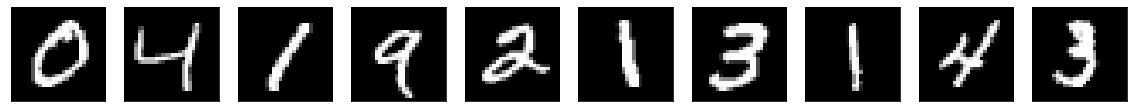

In [ ]:
# check how original image look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Creating Noisy dataset for denoising (Gaussian Noise)
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

##### loc - Mean (“centre”) of the distribution.
#####scale - Standard deviation (spread or “width”) of the distribution. Must be non-negative.
##### size - output shape


In [ ]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5

trainNoise = np.random.normal(loc=0.5, scale=0.8, size=x_train.shape)
testNoise = np.random.normal(loc=0.5, scale=0.8, size=x_test.shape)
x_train = np.clip(x_train + trainNoise, 0, 1)
x_test = np.clip(x_test + testNoise, 0, 1)

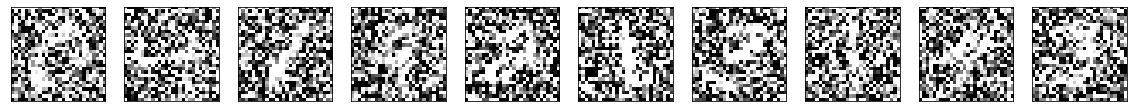

In [ ]:
# check how the noisy images look like

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Set network param (input shape, batch size, kernel size, latent dim, no. of layers + no. of filters)

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64] # there will be 2 layers, 1st - 32 filters, 2nd - 64 filters

# Building the encoder

## 1) Basic encoder

In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# creating conv layers in encoder - [2 layers of Conv2D(32)-Conv2D(64)]
for filters in layer_filters: # layer_filters will indicate no. of conv2d layers set
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)


In [ ]:
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
# Ref: http://tensorflow.biotecan.com/python/Python_1.8/tensorflow.google.cn/api_docs/python/tf/keras/backend/int_shape.html
shape = K.int_shape(x)

In [ ]:
# show the shape of the output after the last conv2d layer in the encoder
shape

(None, 7, 7, 64)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_______________________________________________________

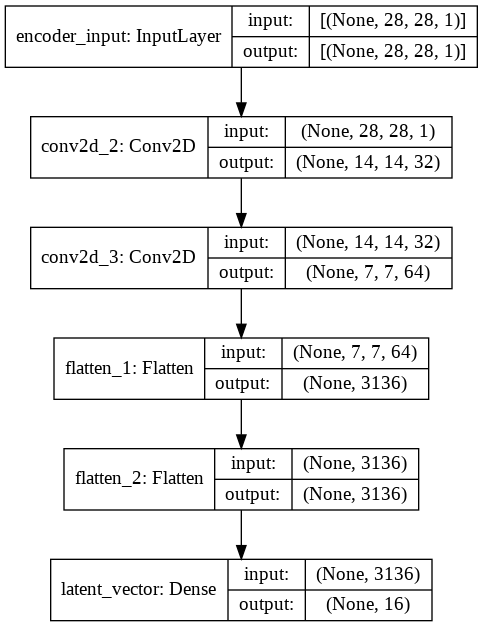

In [ ]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x) # latent dim is specified when setting network params 

# instantiate encoder model (joining the input layer > latent vector)
encoder = Model(inputs,
                latent,
                name='encoder')

# showcase the summary of the encoder - what layers, output shape and param 
encoder.summary()

# plot structure of the encoder in a flowchart figure
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True) # True to show additional details such as the input & output shape


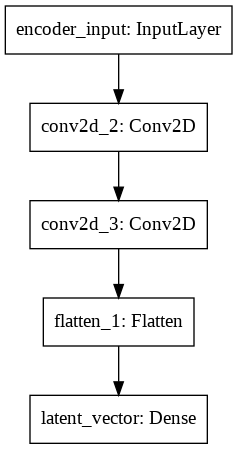

In [ ]:
# plotting the encoder model without show_shapes/ showing the input & output shapes
plot_model(encoder)

# Building the decoder

In [ ]:
# build the decoder model (the output of the latent vector will be the input of the decoder)
latent_inputs = Input(shape=(latent_dim,), name='decoder_input') 

# use the shape (7, 7, 64) that was earlier saved - this is the output shape of the final conv layer in the encoder 
# 7*7*64 = 3136 - shape of the dense layer
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [ ]:
# creating the conv layers in the decoder after the dense layer
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]: # [::-1] is the transpose the position of the filters from [32,64] -> [64,32]
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)


In [ ]:
# original sequence is [32,64]
layer_filters

# transposed sequence is [64,32]
layer_filters [::-1]

[64, 32]

In [ ]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid', # using sigmoid - output btwn 0-1 (usually used for classification purpose)
                          padding='same',
                          name='decoder_output')(x)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

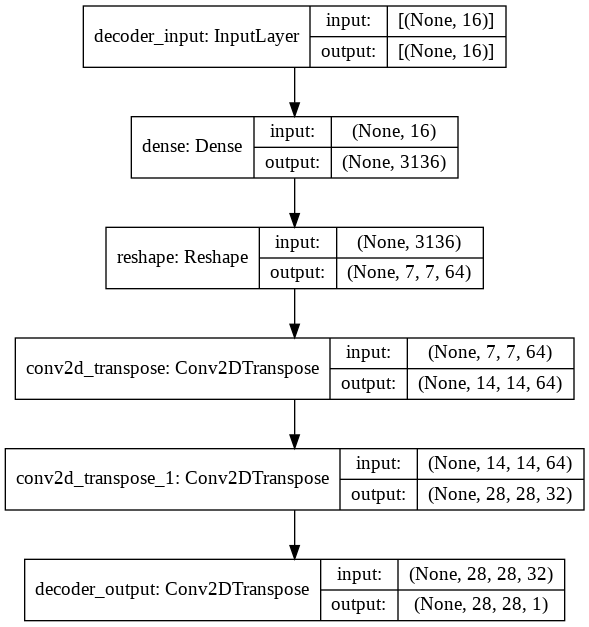

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# plot summary and flowchart of decoder
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)



# Building the autoencoder ( encoder + decoder)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


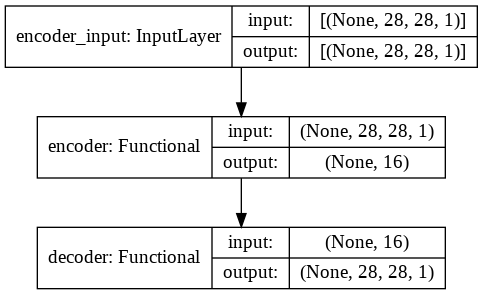

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')

# plot summary and flowchart of autoencoder
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

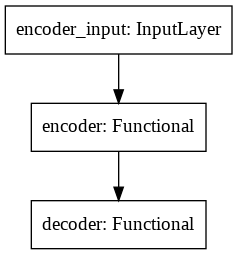

In [ ]:
plot_model(autoencoder)

# Compile & fit model 

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')


In [ ]:
# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10, ## can this be more ? 
                batch_size=batch_size,
                verbose=1)


Epoch 1/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1583 - val_loss: 0.1578
Epoch 2/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1579 - val_loss: 0.1577
Epoch 3/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1578 - val_loss: 0.1577
Epoch 4/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1577 - val_loss: 0.1577
Epoch 5/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1576 - val_loss: 0.1576
Epoch 6/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1576 - val_loss: 0.1576
Epoch 7/10
1875/1875 [==============================] - 89s 47ms/step - loss: 0.1576 - val_loss: 0.1576
Epoch 8/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1575 - val_loss: 0.1576
Epoch 9/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1575 - val_loss: 0.1576
Epoch 10/10
1875/1875 [==============================] - 88s 47m

- despite increasing the number of epoch, the difference of the loss/ val_loss is minimal. 
- which means that you don't have to waste time adding more epoch for deeper learning 
- but this is a simple example with simple grayscale images of number so with more complicated examples, more epoch may be useful 

# Prediction using test set

In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# Results when noise = scale - 0.5
best val loss = 0.1159

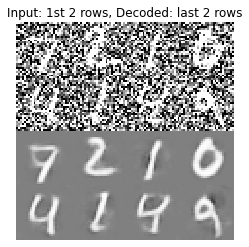

In [ ]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# Results with less noise (scale - 0.1)
best val loss = 0.0110

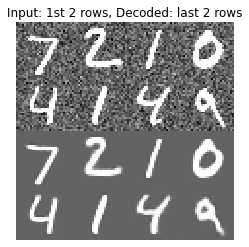

In [ ]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# Results with less noise (scale - 0.8)
best val loss = 0.1403

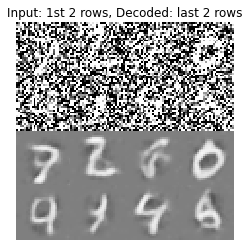

In [ ]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()